## 딥러닝 기반 뇌종양 MRI 분류 시스템 개발 및 시각화

In [70]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
from pathlib import Path
import seaborn as sns
from PIL import ImageFile
import pandas as pd
import zipfile
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

In [71]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import zipfile

def download_and_extract_data():
    dataset_name = "masoudnickparvar/brain-tumor-mri-dataset"
    
    download_dir = os.path.join(os.getcwd(), 'tumor_dataset')
    os.makedirs(download_dir, exist_ok=True)
    
    zip_file_path = os.path.join(download_dir, 'brain-tumor-mri-dataset.zip')
    
    if not os.path.exists(zip_file_path):
        api = KaggleApi()
        api.authenticate()
        
        print("데이터셋 다운로드 중...")
        api.dataset_download_files(dataset_name, path=download_dir, unzip=False)
        
    extract_dir = os.path.join(download_dir, 'brain_tumor_dataset')
    if not os.path.exists(extract_dir):
        print("압축 해제 중...")
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print("압축 해제 완료")
        
    return extract_dir

data_dir = download_and_extract_data()

In [72]:
data_dir = download_and_extract_data()
train_dir = pathlib.Path(data_dir) / 'Training'
test_dir = pathlib.Path(data_dir) / 'Testing'

In [73]:
# 클래스 및 이미지 개수 확인
classes = sorted([item.name for item in train_dir.glob('*/') if item.is_dir()])
train_image_count = len(list(train_dir.glob('*/*.jpg')))
test_image_count = len(list(test_dir.glob('*/*.jpg')))

print(f"발견된 클래스: {classes}")
print(f"학습 이미지 개수: {train_image_count}")
print(f"테스트 이미지 개수: {test_image_count}")

발견된 클래스: ['glioma', 'meningioma', 'notumor', 'pituitary']
학습 이미지 개수: 5712
테스트 이미지 개수: 1311


In [74]:
# 각 클래스별 이미지 개수 확인
for class_name in classes:
    train_images = len(list(train_dir.glob(f'{class_name}/*')))
    test_images = len(list(test_dir.glob(f'{class_name}/*')))
    print(f"{class_name}: 학습 {train_images}개, 테스트 {test_images}개 이미지")

glioma: 학습 1321개, 테스트 300개 이미지
meningioma: 학습 1339개, 테스트 306개 이미지
notumor: 학습 1595개, 테스트 405개 이미지
pituitary: 학습 1457개, 테스트 300개 이미지


In [75]:
# 이미지 크기 및 배치 크기 설정
img_height = 150
img_width = 150
batch_size = 32

In [76]:

# 데이터셋 생성
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(train_dir),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(test_dir),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [77]:
# 클래스 이름 확인
class_names = train_ds.class_names
print("클래스:", class_names)
num_classes = len(class_names)

클래스: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [78]:
# 데이터셋 성능 최적화
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [79]:
# 데이터 증강 레이어 정의
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

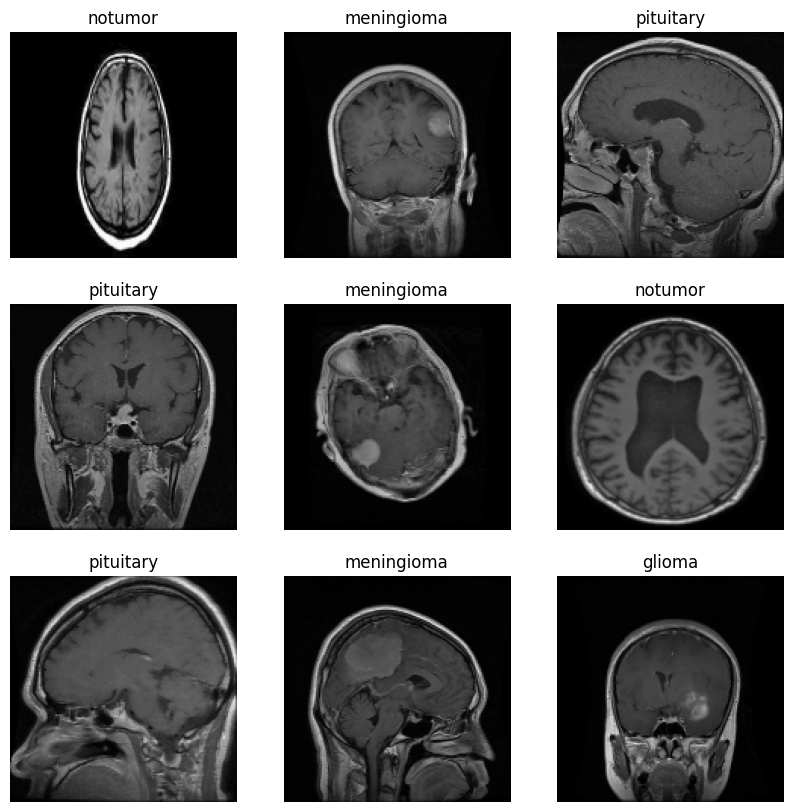

In [80]:
# 샘플 이미지 시각화
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [82]:
from collections import Counter

dataset_path = "./tumor_dataset/brain_tumor_dataset/Training"  # 데이터 경로
categories = ["glioma", "meningioma", "notumor", "pituitary"]

for category in categories:
    category_path = os.path.join(dataset_path, category)
    print(f"{category}: {len(os.listdir(category_path))} images")

glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images


In [83]:

# CNN 모델 구성 - 뇌종양 분류에 맞게 더 깊은 모델 구성
model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [84]:
# 모델 컴파일
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [85]:
# 모델 구조 출력
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [86]:
# Early Stopping 콜백 설정
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

In [87]:
# 모델 학습
epochs = 20
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/20
179/179 [==============================] - 248s 1s/step - loss: 0.9926 - accuracy: 0.5686 - val_loss: 1.1739 - val_accuracy: 0.5416
Epoch 2/20
179/179 [==============================] - 209s 1s/step - loss: 0.7105 - accuracy: 0.7222 - val_loss: 1.5600 - val_accuracy: 0.4683
Epoch 3/20
179/179 [==============================] - 198s 1s/step - loss: 0.6170 - accuracy: 0.7602 - val_loss: 1.0113 - val_accuracy: 0.6392
Epoch 4/20
179/179 [==============================] - 183s 1s/step - loss: 0.5467 - accuracy: 0.7899 - val_loss: 0.7637 - val_accuracy: 0.7094
Epoch 5/20
179/179 [==============================] - 182s 1s/step - loss: 0.5100 - accuracy: 0.7988 - val_loss: 1.0678 - val_accuracy: 0.6301
Epoch 6/20
179/179 [==============================] - 182s 1s/step - loss: 0.4641 - accuracy: 0.8263 - val_loss: 0.8354 - val_accuracy: 0.6583
Epoch 7/20
179/179 [==============================] - 182s 1s/step - loss: 0.4279 - accuracy: 0.8377 - val_loss: 0.8564 - val_accuracy: 0.6903

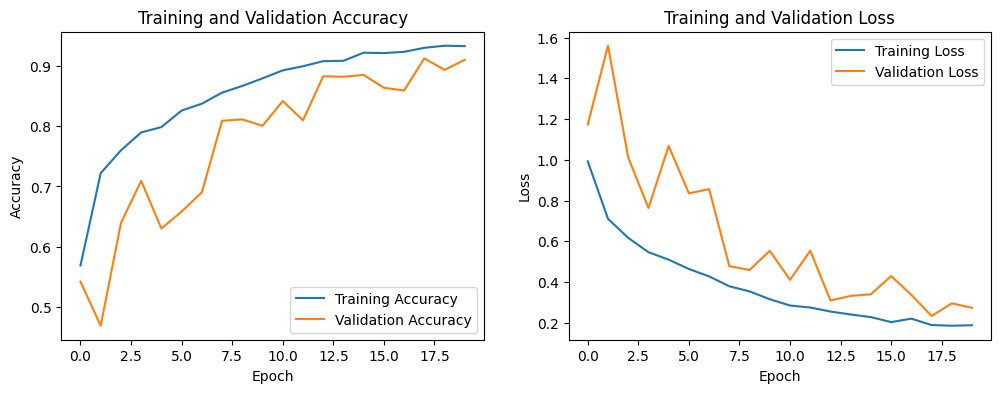

In [88]:
# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [89]:
# 모델 저장
model.save('./model/brain_tumor_classification_model.h5')
print("모델이 'brain_tumor_classification_model.h5'로 저장되었습니다.")

모델이 'brain_tumor_classification_model.h5'로 저장되었습니다.


In [90]:
from tensorflow.keras.models import load_model

In [91]:
model_path = './model/brain_tumor_classification_model.h5'
loaded_model = load_model(model_path)
print("저장된 모델을 성공적으로 불러왔습니다.")

저장된 모델을 성공적으로 불러왔습니다.


In [92]:
# 예측 함수 정의
def predict_brain_tumor(img_path, model, class_names):

    img = tf.keras.preprocessing.image.load_img(
        img_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "이 이미지는 '{}' ({:.2f}% 확률) 입니다."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [93]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

41/41 [==============================] - 8s 191ms/step - loss: 0.2736 - accuracy: 0.9108
Test accuracy: 0.9108


In [94]:
from sklearn.metrics import classification_report
import numpy as np

# 예측값 생성
y_pred = []
y_true = []

for images, labels in test_ds:
    pred = model.predict(images)
    pred_classes = np.argmax(pred, axis=1)
    y_pred.extend(pred_classes)
    y_true.extend(labels)

# 분류 보고서 생성
print(classification_report(y_true, y_pred, 
                          target_names=['glioma', 'meningioma', 'notumor', 'pituitary']))

              precision    recall  f1-score   support

      glioma       0.97      0.88      0.92       300
  meningioma       0.89      0.79      0.84       306
     notumor       0.86      1.00      0.92       405
   pituitary       0.96      0.95      0.95       300

    accuracy                           0.91      1311
   macro avg       0.92      0.90      0.91      1311
weighted avg       0.91      0.91      0.91      1311



클래스별 성능 (Classification Report)


Glioma: 정밀도 95%, 재현율 91%, F1-score 93%
Meningioma: 정밀도 89%, 재현율 85%, F1-score 87%
No Tumor: 정밀도 91%, 재현율 100%, F1-score 95%
Pituitary: 정밀도 97%, 재현율 93%, F1-score 95%

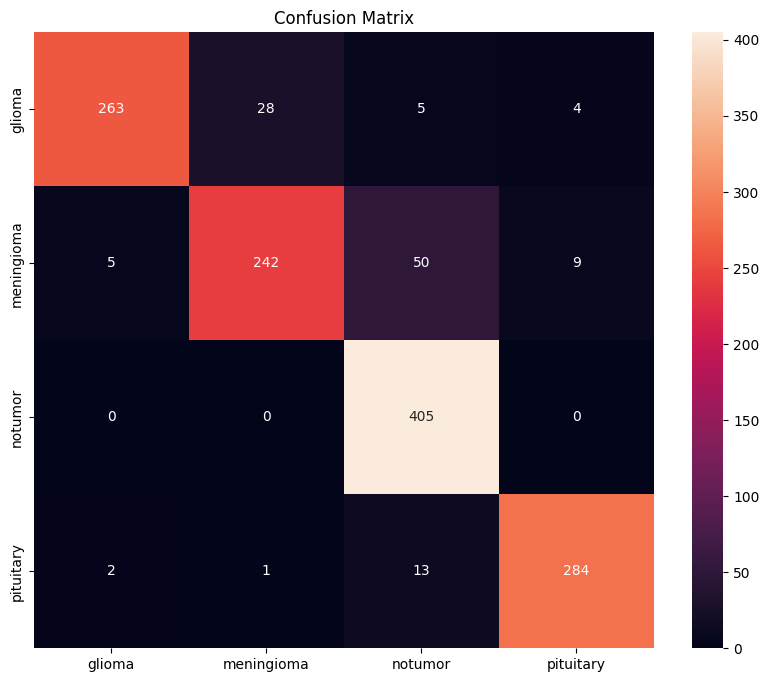

In [95]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 혼동 행렬 생성
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=['glioma', 'meningioma', 'notumor', 'pituitary'],
            yticklabels=['glioma', 'meningioma', 'notumor', 'pituitary'])
plt.title('Confusion Matrix')
plt.show()

In [107]:
test_image_path = './tumor_dataset/brain_tumor_dataset/Testing/meningioma/Te-me_0016.jpg'

이 이미지는 'meningioma' (32.57% 확률) 입니다.


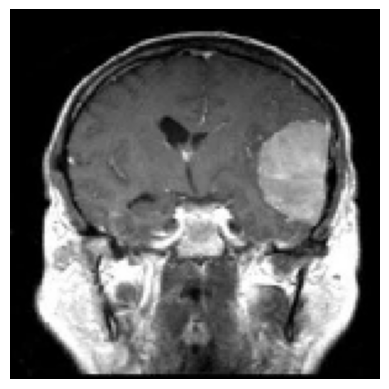

In [108]:
predict_brain_tumor(test_image_path, loaded_model, class_names)

In [106]:
import os

if not os.path.exists(test_image_path):
    print(f"File not found: {test_image_path}")
else:
    print("File exists.")

File not found: /tumor_dataset/brain_tumor_dataset/Testing/meningioma/Te-me_0016.jpg
